**Dependencies**

In [1]:
import sys
from obspy import UTCDateTime
from DataDownload import *
from StreamProcessing import *
from EventIdentification import *
from CataloguedEvents import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime


**Set Date And Station**

In [2]:
date = UTCDateTime("2024-04-23") 

# station = ['GB', 'EDMD', 'IRIS']
station = ['AM','R50D6','https://data.raspberryshake.org']

# get the coordination for the station
station_coordinates = get_coordinates(station)

# Try to download data and return availability for the date
data_available = download_seismic_data(date, station)

Data for 2024-04-23 already downloaded.


**Original Stream**

1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-04-22T23:00:00.004000Z - 2024-04-24T01:00:00.004000Z | 100.0 Hz, 9360001 samples


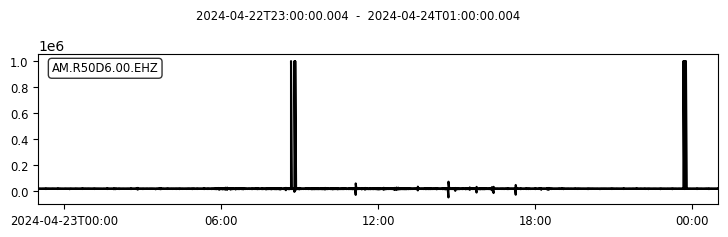

In [3]:
# Get stream from mseed file using date and st
stream = get_stream(date, station)
print(stream)

# Before processing
stream.plot()
plt.show()
plt.close()

**Processed Stream**

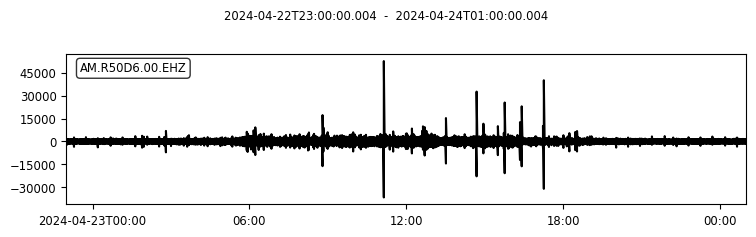

In [4]:
processed_stream = stream_process(stream)
processed_stream.plot()
plt.show()
plt.close()

**Find Earthquake From Catalogue**

Number of Identified Earthquakes: 5
5 Event(s) in Catalog:
2024-04-23T15:40:05.079000Z | +38.158,  -30.835 | 5.2  Mww
2024-04-23T13:05:39.336000Z | +50.100,  -28.970 | 5.0  mww
2024-04-23T02:21:00.008000Z | +23.833, +121.610 | 5.2  Mwr
2024-04-23T00:11:02.661000Z | +23.898, +121.598 | 5.2  mb
2024-04-23T00:04:05.608000Z | +23.803, +121.676 | 5.8  mww


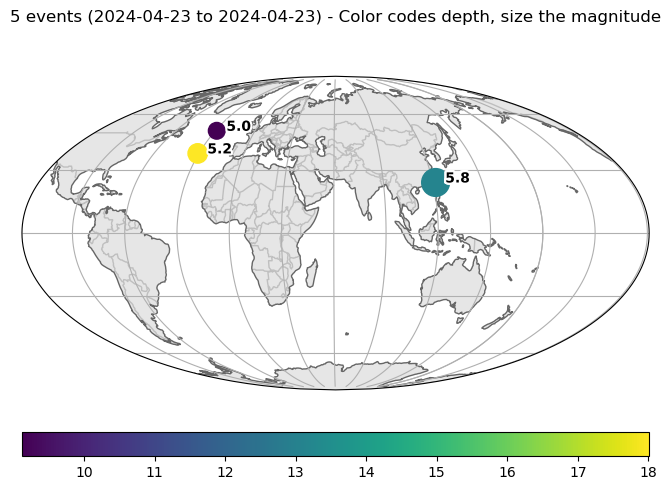

In [5]:
catalogued_earthquakes = find_earthquakes(
    catalogue_provider='IRIS',
    latitude=station_coordinates[0],
    longitude=station_coordinates[1],
    date = date,
    radmin=0,
    radmax=90,
    minmag=5,
    maxmag=10
)

print_catalogued(catalogued_earthquakes)

**Create a DataFrame for Events with Predicted Arrival Times**

In [6]:
df_catalogued = create_df_with_prediction(catalogued_earthquakes, station_coordinates)
df_catalogued

,time,lat,long,mag,mag_type,P_predict,S_predict,catalogued,detected,detected_start
0,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,2024-04-23T15:45:38.306903,2024-04-23T15:50:13.431885,True,False,None
1,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,2024-04-23T13:09:42.627392,2024-04-23T13:13:20.674606,True,False,None
2,2024-04-23T02:21:00.008000,23.8333,121.6102,5.2,Mwr,2024-04-23T02:33:48.823173,2024-04-23T02:44:31.345600,True,False,None
3,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,2024-04-23T00:23:50.629125,2024-04-23T00:34:32.470403,True,False,None
4,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,2024-04-23T00:16:54.171368,2024-04-23T00:27:36.589723,True,False,None


**Identify Earthquakes Inside Time Window Using STA/ LTA**

In [7]:
# Produce segments using time windows created from predicted arrival times
trace_in_time_window= extract_trace_inside_window(df_catalogued, processed_stream)

sta_window = 1  # Short-time window in seconds
lta_window = 30.0  # Long-time window in seconds
threshold_on = 4  # STA/LTA threshold for triggering
threshold_off = 2  # STA/LTA threshold for turning off the trigger

earthquake_times = detect_earthquakes(trace_in_time_window, sta_window, lta_window, threshold_on, threshold_off)
earthquake_times 

[(2024-04-23T15:47:35.654000Z, 2024-04-23T15:47:37.354000Z),
 (2024-04-23T13:09:50.774000Z, 2024-04-23T13:09:51.764000Z)]

**Mark Identified Times and Predicted Times Onto Traces**

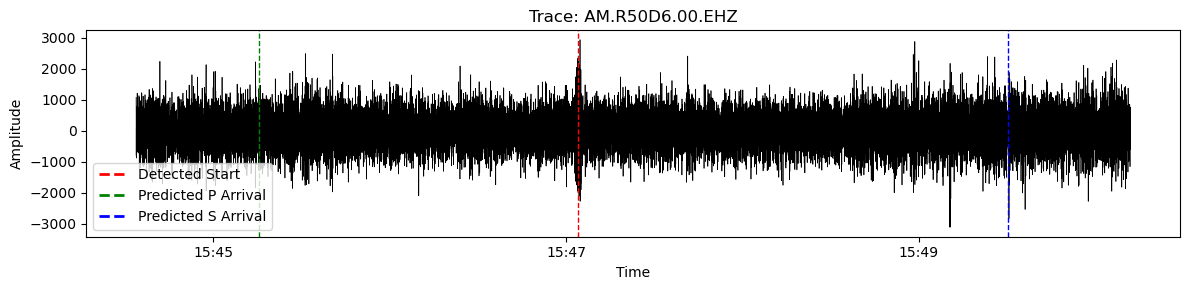

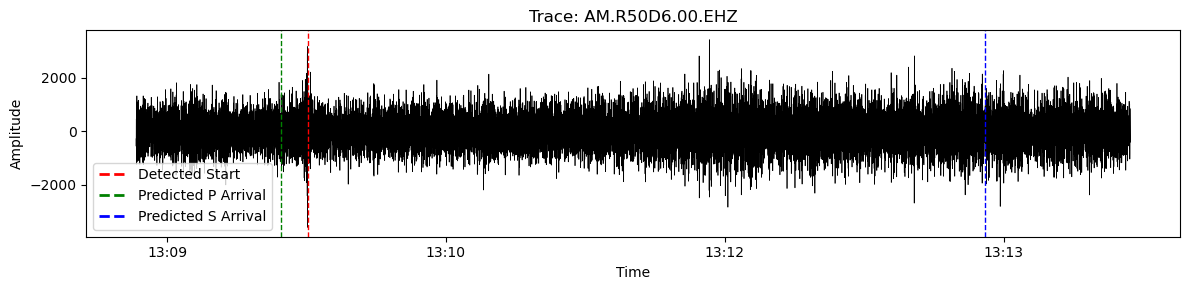

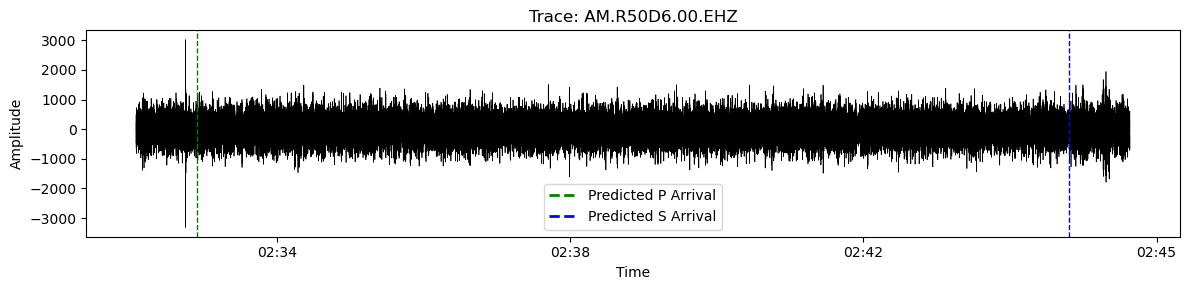

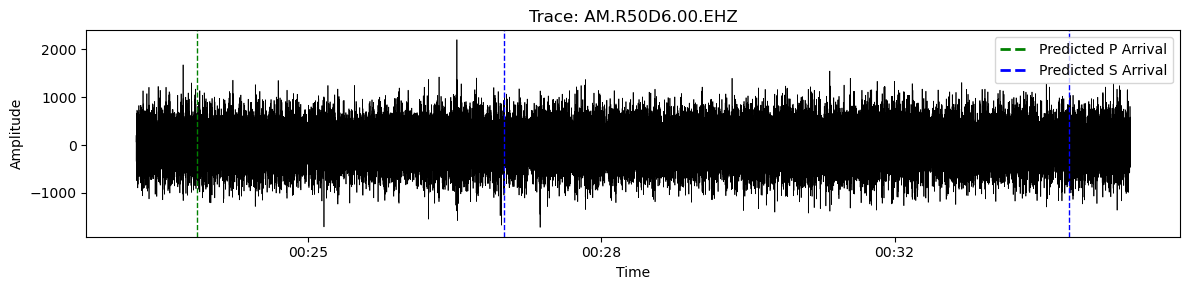

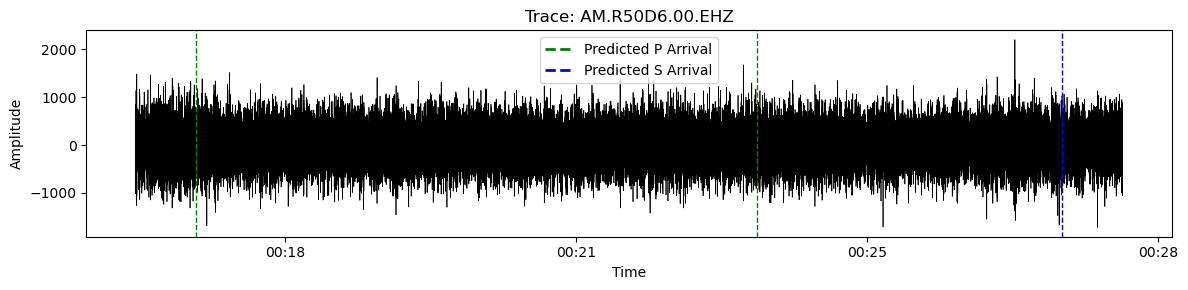

In [8]:
predicted_p_times = df_catalogued['P_predict'].tolist()  
predicted_s_times = df_catalogued['S_predict'].tolist()  

# Now we call the function with all necessary data
for trace in trace_in_time_window:
    plot_identified_prediction(trace, earthquake_times, predicted_p_times, predicted_s_times)


In [9]:
df_catalogued_matched = match_catalogue(df_catalogued, earthquake_times)
df_catalogued_matched 

,time,lat,long,mag,mag_type,P_predict,S_predict,catalogued,detected,detected_start
0,2024-04-23T15:40:05.079000,38.1576,-30.8347,5.2,Mww,2024-04-23T15:45:38.306903,2024-04-23T15:50:13.431885,True,False,None
1,2024-04-23T13:05:39.336000,50.0999,-28.9704,5.0,mww,2024-04-23T13:09:42.627392,2024-04-23T13:13:20.674606,True,True,2024-04-23T13:09:50.774000
2,2024-04-23T02:21:00.008000,23.8333,121.6102,5.2,Mwr,2024-04-23T02:33:48.823173,2024-04-23T02:44:31.345600,True,False,None
3,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,2024-04-23T00:23:50.629125,2024-04-23T00:34:32.470403,True,False,None
4,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,2024-04-23T00:16:54.171368,2024-04-23T00:27:36.589723,True,False,None


**Identify Earthquakes Outside Time Window Using STA/ LTA**

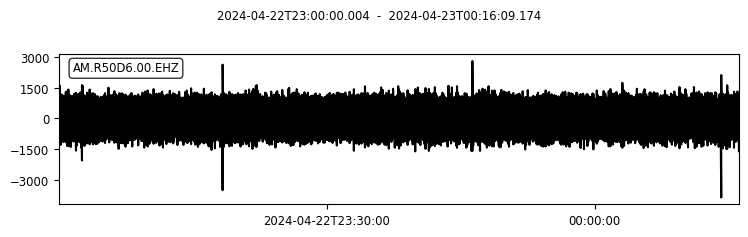

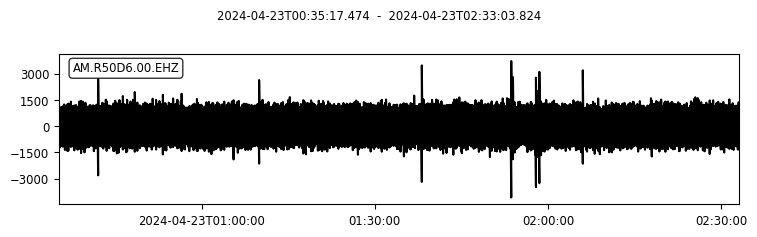

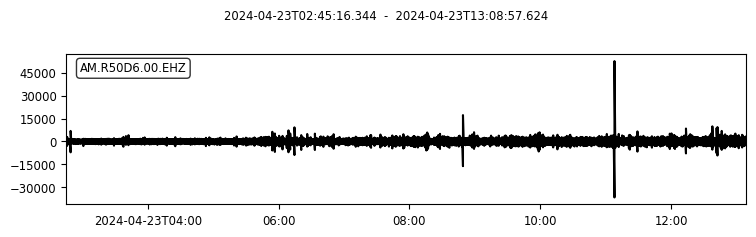

C:\Users\isola\anaconda3\envs\obspy\lib\site-packages\obspy\imaging\util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small')
C:\Users\isola\anaconda3\envs\obspy\lib\site-packages\obspy\imaging\waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  plt.setp(ax.get_xticklabels(), fontsize='small',


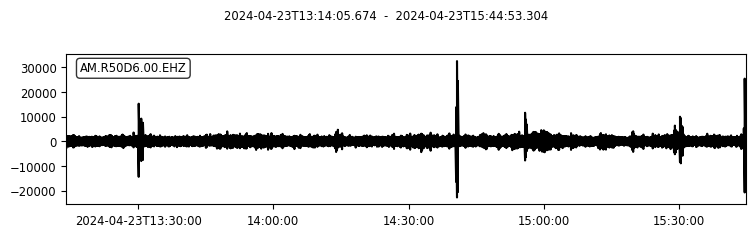

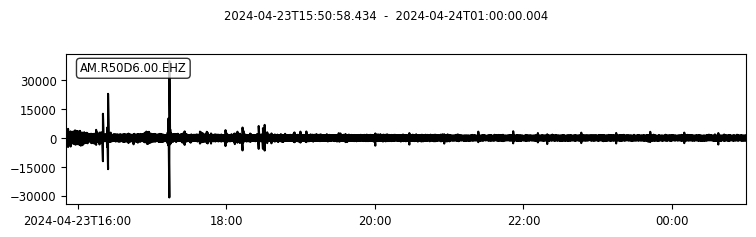

In [10]:
trace_outside_time_window= extract_trace_outside_window(df_catalogued, processed_stream)

for trace in trace_outside_time_window:
    trace.plot()

**Identify Earthquakes Not In Catalogue**

In [11]:
uncatalogued_earthquake_times = detect_earthquakes(trace_outside_time_window, sta_window, lta_window, threshold_on, threshold_off)
uncatalogued_earthquake_times  

[(2024-04-23T00:14:04.944000Z, 2024-04-23T00:14:05.634000Z),
 (2024-04-23T01:53:34.894000Z, 2024-04-23T01:53:36.334000Z),
 (2024-04-23T01:57:54.454000Z, 2024-04-23T01:57:55.974000Z),
 (2024-04-23T01:58:27.644000Z, 2024-04-23T01:58:29.384000Z),
 (2024-04-23T02:46:01.704000Z, 2024-04-23T02:46:03.054000Z),
 (2024-04-23T02:46:22.944000Z, 2024-04-23T02:46:23.384000Z),
 (2024-04-23T02:49:19.334000Z, 2024-04-23T02:49:22.004000Z),
 (2024-04-23T02:49:50.384000Z, 2024-04-23T02:49:52.554000Z),
 (2024-04-23T03:37:44.304000Z, 2024-04-23T03:37:44.864000Z),
 (2024-04-23T03:40:16.854000Z, 2024-04-23T03:40:18.424000Z),
 (2024-04-23T03:42:14.604000Z, 2024-04-23T03:42:16.174000Z),
 (2024-04-23T04:17:20.354000Z, 2024-04-23T04:17:21.204000Z),
 (2024-04-23T05:05:57.944000Z, 2024-04-23T05:05:59.244000Z),
 (2024-04-23T05:06:33.034000Z, 2024-04-23T05:06:34.394000Z),
 (2024-04-23T05:29:55.034000Z, 2024-04-23T05:29:56.024000Z),
 (2024-04-23T05:38:03.964000Z, 2024-04-23T05:38:04.334000Z),
 (2024-04-23T05:44:13.34